In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [3]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [4]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [5]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [6]:
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [7]:
print(rel.feature_importances_)

[0.13359498 0.48668844 0.2801152  0.09960138]


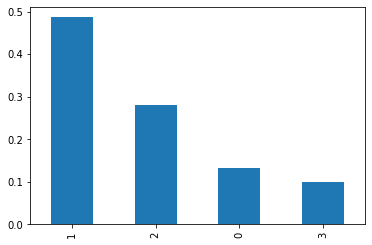

In [8]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [9]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [10]:
ordered_f.head(10)

1    0.340362
2    0.269927
0    0.060894
3    0.006152
dtype: float64

In [11]:
test_ratio = 0.2
seed = 1984
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

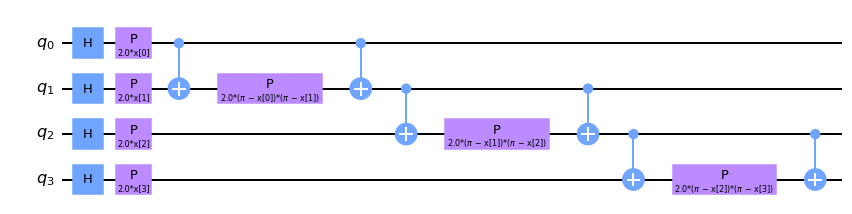

In [12]:
feature_dim = x.shape[1]
emb_layer = 1
ent = 'linear'

fmap = ZZFeatureMap(feature_dimension=feature_dim, reps=emb_layer, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

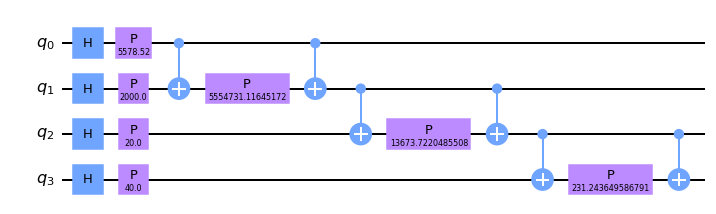

In [13]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

In [14]:
def ansatz_circ(feature_dim, layer, weights):
    ansatz = QuantumCircuit(feature_dim)
    for layer in range(layer):
        for i in range(feature_dim):
            ansatz.ry(weights[i], i)
            #ansatz.rz(weights[i+4], i)
        for i in range(feature_dim - 1):
            ansatz.cx(i, i+1)
        ansatz.cx(3,0)
        ansatz.barrier()
    return ansatz

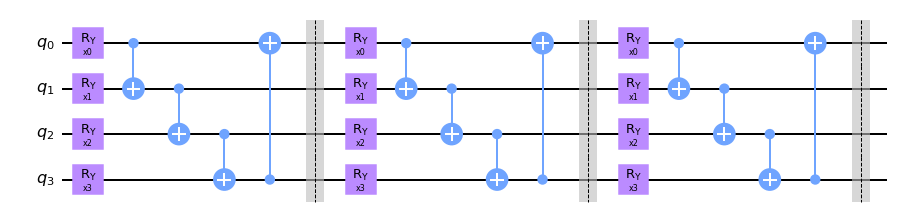

In [15]:
layer = 3
np.random.seed(seed)
nb_w = 4
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

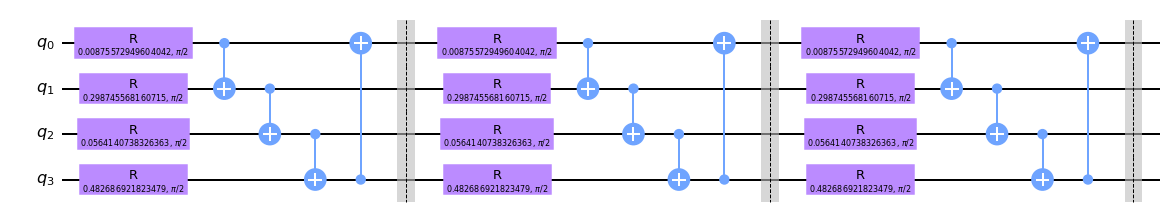

In [16]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

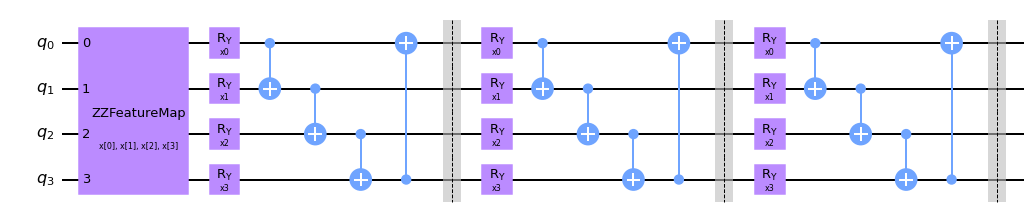

In [17]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [18]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [19]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [20]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [21]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.50927734, 0.49072266]])

In [22]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.15771484, -0.00366211,  0.21850586, -0.03466797],
        [-0.15771484,  0.00366211, -0.21850586,  0.03466797]]])

In [23]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [24]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [25]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 315.249573085304
6 - 307.1094888250574
9 - 307.36790193651893
12 - 306.1692135836064
15 - 307.9170002941489
18 - 306.8332918906105
21 - 307.13846467752
24 - 307.5283416078507
27 - 306.9135782794856
30 - 307.224315876669
33 - 306.75667319511444
36 - 306.07759299699205
39 - 304.60688940717205
42 - 304.84873164069234
45 - 304.45054179106677
48 - 303.8960041342941
51 - 303.0148449452937
54 - 302.6157678535984
57 - 302.9391234822921
60 - 300.35402702970714
63 - 299.31664539626297
66 - 299.1964892141849
69 - 298.82146251324946
72 - 298.0807765725946
75 - 298.284171854155
78 - 297.7899205078821
81 - 297.64204358890436
84 - 297.6114281771978
87 - 297.6240407231033
90 - 297.7215081108369
93 - 297.0415655106749
96 - 297.5222558367449
99 - 297.1653757154336
102 - 297.246930077359
105 - 297.2529433228059
108 - 297.39743553773974
111 - 297.467723737961
114 - 297.48729527541053
117 - 297.3646196219598
120 - 297.2364242953735
123 - 297.1755095819939
126 - 297.19184812654936
129 - 296.846319483858

In [26]:
score_train_1 = vqc.score(x_train, y_train_1h)
score_test_1 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_1}')
print(f'Score on the test set {score_test_1}')

Score on the train set 0.5666666666666667
Score on the test set 0.5416666666666666


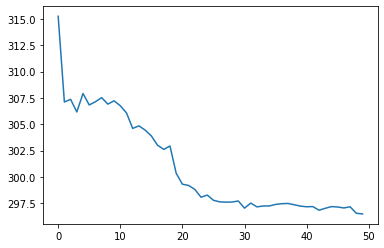

In [27]:
plt.plot(loss_recorder)

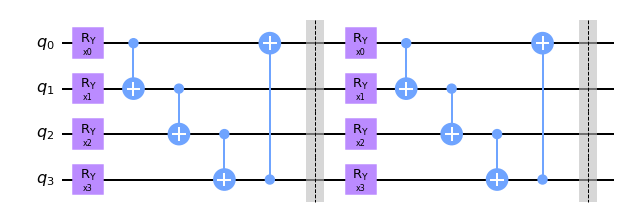

In [28]:
layer = 2
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

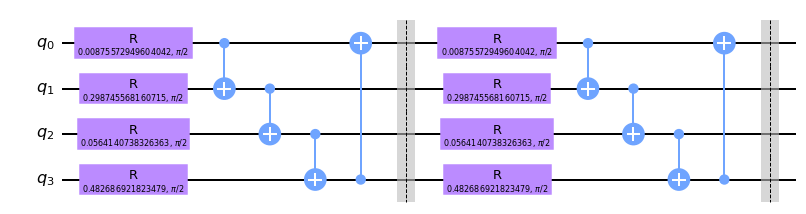

In [29]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

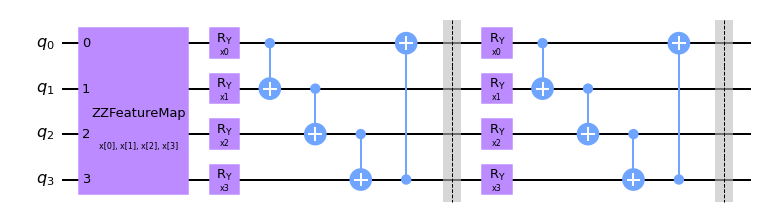

In [30]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [31]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [32]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.53466797, 0.46533203]])

In [33]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.04321289,  0.10302734,  0.00878906,  0.04296875],
        [-0.04321289, -0.10302734, -0.00878906, -0.04296875]]])

In [34]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 304.0123252744295
6 - 313.9248239921686
9 - 311.1517111854546
12 - 307.9473565355861
15 - 310.3906125832591
18 - 310.4059860125657
21 - 308.1171551736722
24 - 302.6375061573327
27 - 304.2985835278245
30 - 304.1011642361019
33 - 304.82850835988546
36 - 304.60149561546746
39 - 305.39902242212
42 - 305.822773418429
45 - 304.89429210878734
48 - 304.7484783996828
51 - 304.5119193615135
54 - 304.5403540073637
57 - 304.4807760878183
60 - 304.057961987163
63 - 302.4247450990128
66 - 300.57660016817937
69 - 300.2063346467578
72 - 299.27371405253814
75 - 298.58444802731447
78 - 298.1155207597469
81 - 297.3631809669729
84 - 297.42307594572856
87 - 296.7718571126959
90 - 296.169326530945
93 - 295.8540337129275
96 - 295.9665183052142
99 - 295.2831487967501
102 - 295.2455506474081
105 - 295.14331577571124
108 - 294.9162340094616
111 - 294.9556505505799
114 - 294.7706467212148
117 - 294.81726695986845
120 - 294.8130723537512
123 - 294.78818367340796
126 - 294.7819383411984
129 - 294.8337267967697

In [35]:
score_train_2 = vqc.score(x_train, y_train_1h)
score_test_2 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_2}')
print(f'Score on the test set {score_test_2}')

Score on the train set 0.5233333333333333
Score on the test set 0.5333333333333333


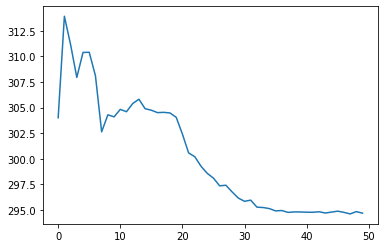

In [36]:
plt.plot(loss_recorder)

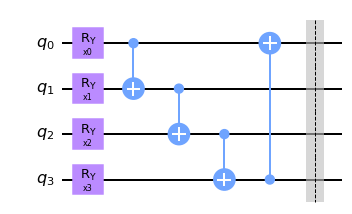

In [37]:
layer = 1
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

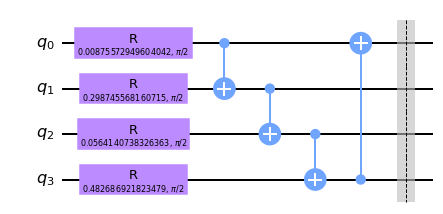

In [38]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

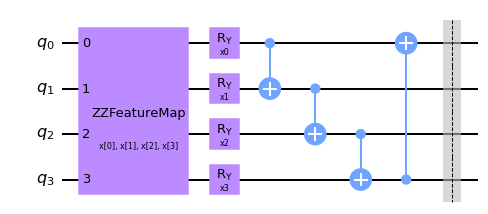

In [39]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [40]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [41]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.50341797, 0.49658203]])

In [42]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.00219727,  0.02929687, -0.06469727,  0.03979492],
        [-0.00219727, -0.02929687,  0.06469727, -0.03979492]]])

In [43]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 301.16150918619115
6 - 299.2801857700654
9 - 298.25386965999985
12 - 297.92586365590205
15 - 297.7011764312019
18 - 297.8160085261052
21 - 297.25646247513913
24 - 297.0630419687137
27 - 297.18935424184565
30 - 296.8598269228189
33 - 297.0355249325654
36 - 296.97640188591123
39 - 297.01920573993186
42 - 297.0913689445698
45 - 297.08452111465806
48 - 297.158035952055
51 - 297.2027142600048
54 - 296.7318749235974
57 - 296.9946198731459
60 - 296.98620755072426
63 - 296.6762839100826
66 - 296.27196838546587
69 - 296.2948401269249
72 - 296.41332514204385
75 - 296.3169417859198
78 - 296.39219764697236
81 - 296.39666038174084
84 - 296.44087118265577
87 - 296.4001076426916
90 - 296.3577968594489
93 - 296.051881719819
96 - 296.0693108389495
99 - 296.3724503608347
102 - 296.3624727762322
105 - 296.4363982524945
108 - 296.39460808315175
111 - 296.37860698211466
114 - 296.2736792875899
117 - 296.39332895595015
120 - 296.3347288800787
123 - 296.1122830500991
126 - 296.29231534453845
129 - 296.22

In [44]:
score_train_3 = vqc.score(x_train, y_train_1h)
score_test_3 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_3}')
print(f'Score on the test set {score_test_3}')

Score on the train set 0.52
Score on the test set 0.475


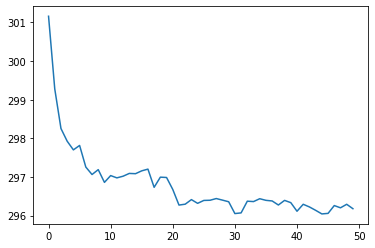

In [45]:
plt.plot(loss_recorder)